# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>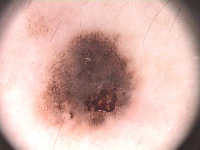</td><td>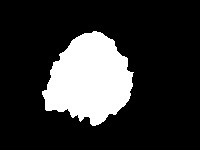</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [0]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2020-05-26 14:42:58--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-05-26 14:42:59--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucec3180f7327f1cdd658e0adec1.dl.dropboxusercontent.com/cd/0/inline/A4cPcrjbNbfWt6wJo6LJsSl2iRT0B3jMW8C4leWJCpPv_5nHtYeEfHygWvWxgoBGxvLmBet8lVw2An56Q7EeDOtYHho6DtBxj9_Z-nhVW5OPPg/file# [following]
--2020-05-26 14:42:59--  https://ucec3180f7327f1cdd658e0adec1.dl.dropboxusercontent.com/cd/0/inline/A4cPcrjbNbfWt6wJo6LJsSl2iRT0B3jMW8C4leWJCpPv_5nHtYeEfHygWvWxgoBGxvLmBet8lVw2An56Q7EeDOtYHho6DtBxj9_Z-nhVW5OPPg/file
Resolving 

In [0]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [0]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [0]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [0]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [0]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

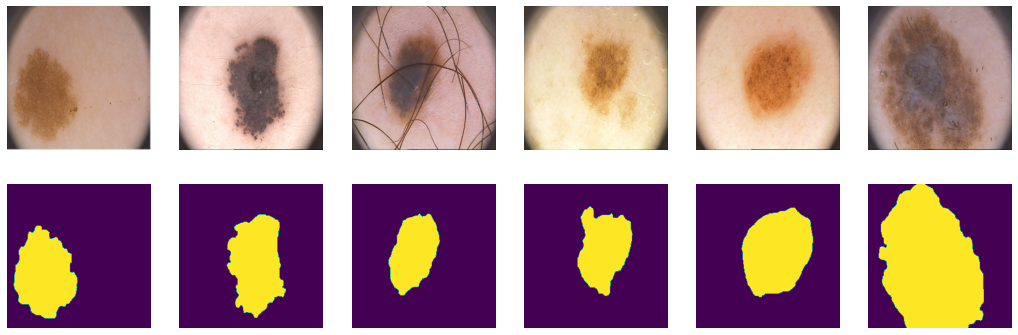

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [0]:
seed = 42
np.random.seed(seed) # это я сделал уже для тестов в конце, чтобы одинаковые сиды были 

ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [0]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [0]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [0]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

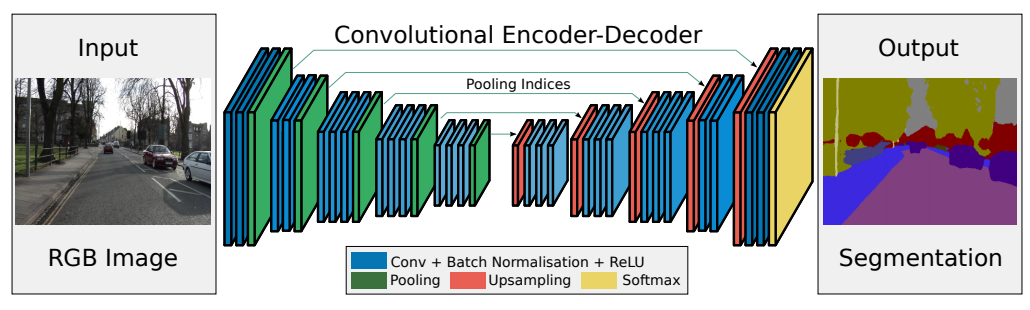

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [0]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
 
        # encoder (downsampling)
        self.enc_conv01 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bnorm01 = nn.BatchNorm2d(32)
        self.enc_conv02 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bnorm02 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
 
        self.enc_conv11 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bnorm11 = nn.BatchNorm2d(64)
        self.enc_conv12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bnorm12 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
 
        self.enc_conv21 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bnorm21 = nn.BatchNorm2d(128)
        self.enc_conv22 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bnorm22 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
 
        self.enc_conv31 =nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bnorm31 = nn.BatchNorm2d(256)
        self.enc_conv32 =nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bnorm32 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16
 
        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)
 
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv01 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bnorm_01 = nn.BatchNorm2d(256)
        self.dec_conv02 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_02 = nn.BatchNorm2d(128)
 
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv11 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_11 = nn.BatchNorm2d(128)
        self.dec_conv12 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_12 = nn.BatchNorm2d(64)
 
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv21 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_21 = nn.BatchNorm2d(64)
        self.dec_conv22 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_22 = nn.BatchNorm2d(32)
 
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv31 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_3 = nn.BatchNorm2d(32)
        self.dec_conv32 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
 
    def forward(self, x):
        # encoder
        e1 = F.relu(self.bnorm01(self.enc_conv01(x)))
        e2 = F.relu(self.bnorm02(self.enc_conv02(e1)))
        e3, idx0 = self.pool0(e2)
 
        e4 = F.relu(self.bnorm11(self.enc_conv11(e3)))
        e5 = F.relu(self.bnorm12(self.enc_conv12(e4)))
        e6, idx1 = self.pool1(e5)
       
        e7 = F.relu(self.bnorm21(self.enc_conv21(e6)))
        e8 = F.relu(self.bnorm22(self.enc_conv22(e7)))
        e9, idx2 = self.pool2(e8)
 
        e10 = F.relu(self.bnorm31(self.enc_conv31(e9)))
        e11 = F.relu(self.bnorm32(self.enc_conv32(e10)))
        e12, idx3 = self.pool3(e11)
       
        # bottleneck
        b = F.relu(self.bottleneck_conv(e12))
 
        # decoder
        d1 = self.upsample0(b, idx3)
        d2 = F.relu(self.bnorm_01(self.dec_conv01(d1)))
        d3 = F.relu(self.bnorm_02(self.dec_conv02(d2)))
 
        d4 = self.upsample1(d3, idx2)
        d5 = F.relu(self.bnorm_11(self.dec_conv11(d4)))
        d6 = F.relu(self.bnorm_12(self.dec_conv12(d5)))
       
        d7 = self.upsample2(d6, idx1)
        d8 = F.relu(self.bnorm_21(self.dec_conv21(d7)))
        d9 = F.relu(self.bnorm_22(self.dec_conv22(d8)))
 
        d10 = self.upsample3(d9, idx0)
        d11 = F.relu(self.bnorm_3(self.dec_conv31(d10)))
        d12 = self.dec_conv32(d11)
 
        return d12   # no activation

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [0]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [0]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    loss =  (y_pred.clamp(min=0) - y_pred * y_real + (1 + (-y_pred.abs()).exp()).log()).mean()
    return loss

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [0]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch.to(device))
            loss = loss_fn(Y_batch,Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu().numpy() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [0]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [0]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred>0.5, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

In [0]:
model = SegNet().to(device)

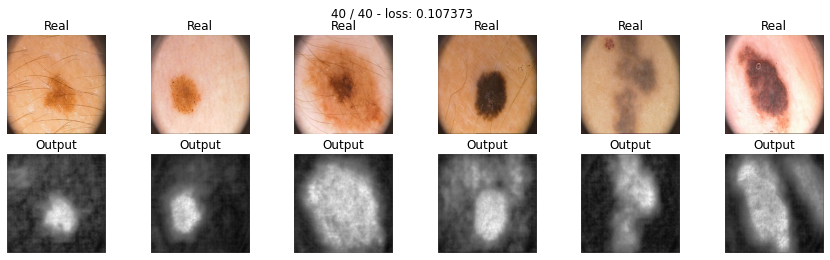

In [0]:
max_epochs = 40
optim = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(model, iou_pytorch,data_val)

0.5960000157356262

In [0]:
torch.cuda.empty_cache()

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [0]:
def dice_loss(y_real, y_pred):
    
    smooth = 1.
    
    iflat = y_pred.contiguous().view(-1)
    tflat = y_real.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

Проводим тестирование:

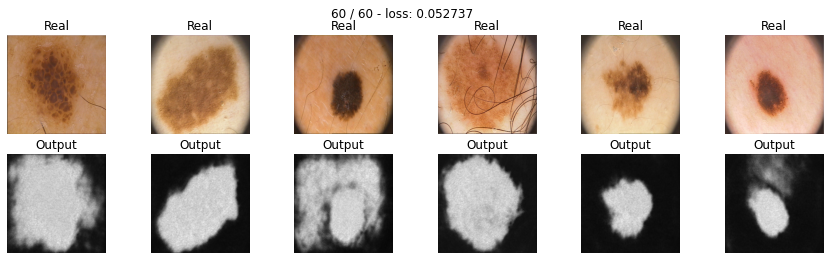

In [0]:
model_dice = SegNet().to(device)

max_epochs = 60
optimaizer = torch.optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(model_dice, iou_pytorch, data_val)

0.5699999928474426

In [0]:
torch.cuda.empty_cache()

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [0]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    #y_pred =  # hint: torch.clamp
    your_loss = -(((1 - F.sigmoid(y_pred))*(1-F.sigmoid(y_pred))*y_real*torch.log(F.sigmoid(y_pred))+(1-y_real)*torch.log(1-F.sigmoid(y_pred))).mean())
    return your_loss

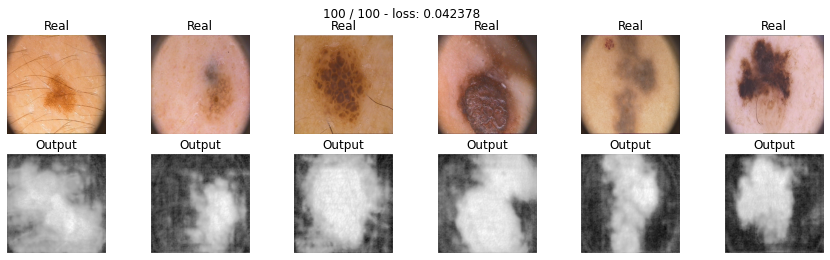

In [0]:
model_focal = SegNet().to(device)

max_epochs = 100
optimaizer = torch.optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(model_focal, iou_pytorch, data_val)

0.6679999828338623

In [0]:
torch.cuda.empty_cache()

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [0]:
def tversky_loss(y_true, y_pred, beta = 0.15):
  y_pred = torch.sigmoid(y_pred)
  axes = tuple(range(1,len(y_pred.shape)-1))
  numerator = torch.sum(y_true * y_pred, axis=axes)
  denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)

  loss = 1 - (numerator + 1) / (torch.sum(denominator, axis=axes) + 1)
  return loss.mean()

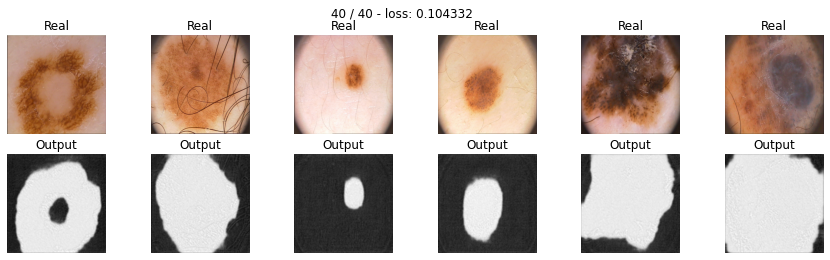

In [0]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, tversky_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(model_dice, iou_pytorch, data_val)

0.502000018954277

In [0]:
torch.cuda.empty_cache()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

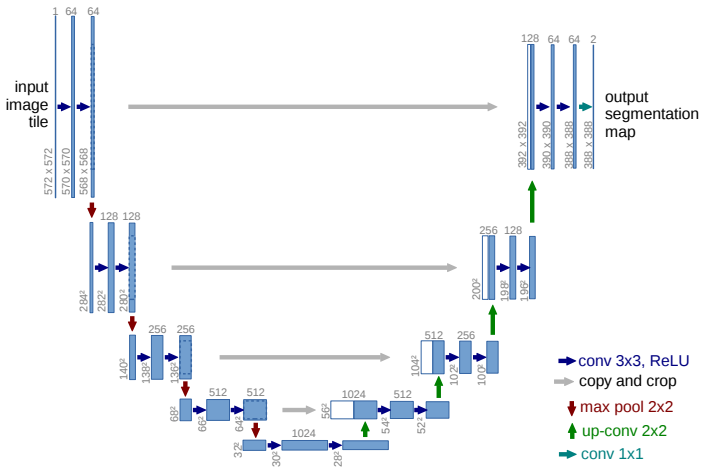

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [0]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
 
        # encoder (downsampling)
        self.enc_conv01 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bnorm01 = nn.BatchNorm2d(32)
        self.enc_conv02 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bnorm02 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
 
        self.enc_conv11 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bnorm11 = nn.BatchNorm2d(64)
        self.enc_conv12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bnorm12 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
 
        self.enc_conv21 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bnorm21 = nn.BatchNorm2d(128)
        self.enc_conv22 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bnorm22 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
 
        self.enc_conv31 =nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bnorm31 = nn.BatchNorm2d(256)
        self.enc_conv32 =nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bnorm32 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16
 
        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)
 
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv01 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.bnorm_01 = nn.BatchNorm2d(256)
        self.dec_conv02 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_02 = nn.BatchNorm2d(128)
 
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv11 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_11 = nn.BatchNorm2d(128)
        self.dec_conv12 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_12 = nn.BatchNorm2d(64)
 
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv21 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_21 = nn.BatchNorm2d(64)
        self.dec_conv22 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_22 = nn.BatchNorm2d(32)
 
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv31 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_3 = nn.BatchNorm2d(32)
        self.dec_conv32 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
 
    def forward(self, x):
        # encoder
        e1 = F.relu(self.bnorm01(self.enc_conv01(x)))
        e2 = F.relu(self.bnorm02(self.enc_conv02(e1)))
        e3, idx0 = self.pool0(e2)
 
        e4 = F.relu(self.bnorm11(self.enc_conv11(e3)))
        e5 = F.relu(self.bnorm12(self.enc_conv12(e4)))
        e6, idx1 = self.pool1(e5)
       
        e7 = F.relu(self.bnorm21(self.enc_conv21(e6)))
        e8 = F.relu(self.bnorm22(self.enc_conv22(e7)))
        e9, idx2 = self.pool2(e8)
 
        e10 = F.relu(self.bnorm31(self.enc_conv31(e9)))
        e11 = F.relu(self.bnorm32(self.enc_conv32(e10)))
        e12, idx3 = self.pool3(e11)
       
        # bottleneck
        b = F.relu(self.bottleneck_conv(e12))
 
        # decoder
        d1 = self.upsample0(b, idx3)
        d2 = torch.cat([d1, e11], dim=1)
        d3 = F.relu(self.bnorm_01(self.dec_conv01(d2)))
        d4 = F.relu(self.bnorm_02(self.dec_conv02(d3)))
 
        d5 = self.upsample1(d4, idx2)
        d6 = torch.cat([d5, e8], dim=1)
        d7 = F.relu(self.bnorm_11(self.dec_conv11(d6)))
        d8 = F.relu(self.bnorm_12(self.dec_conv12(d7)))
       
        d9 = self.upsample2(d8, idx1)
        d10 = torch.cat([d9, e5], dim=1)
        d11 = F.relu(self.bnorm_21(self.dec_conv21(d10)))
        d12 = F.relu(self.bnorm_22(self.dec_conv22(d11)))
 
        d13 = self.upsample3(d12, idx0)
        d14 = torch.cat([d13, e2], dim=1)
        d15 = F.relu(self.bnorm_3(self.dec_conv31(d14)))
        d16 = torch.sigmoid(self.dec_conv32(d15))
 
        return d16

In [0]:
unet_model = UNet().to(device)

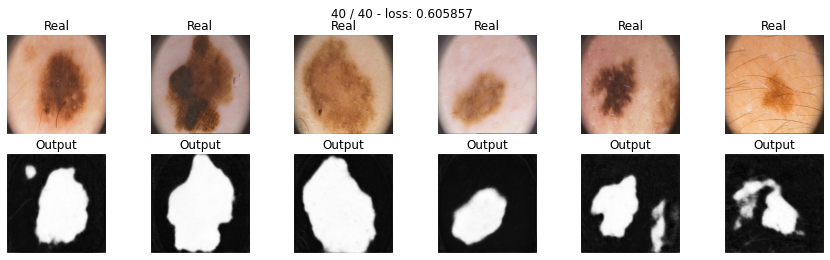

In [0]:
train(unet_model, torch.optim.Adam(unet_model.parameters(), lr=0.0001), bce_loss, 40, data_tr, data_val)

In [0]:
score_model(unet_model, iou_pytorch, data_val)

0.7159999907016754

In [0]:
torch.cuda.empty_cache()

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [0]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
 
        # encoder (downsampling)
        self.enc_conv01 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bnorm01 = nn.BatchNorm2d(32)
        self.enc_conv02 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bnorm02 = nn.BatchNorm2d(32)
        self.pool0 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, stride=2)  # 256 -> 128
 
        self.enc_conv11 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bnorm11 = nn.BatchNorm2d(64)
        self.enc_conv12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bnorm12 = nn.BatchNorm2d(64)
        self.pool1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # 128 -> 64
 
        self.enc_conv21 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bnorm21 = nn.BatchNorm2d(128)
        self.enc_conv22 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bnorm22 = nn.BatchNorm2d(128)
        self.pool2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # 64 -> 32
 
        self.enc_conv31 =nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bnorm31 = nn.BatchNorm2d(256)
        self.enc_conv32 =nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bnorm32 = nn.BatchNorm2d(256)
        self.pool3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 32 -> 16
 
        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)
 
        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=256, out_channels =256, kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv01 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.bnorm_01 = nn.BatchNorm2d(256)
        self.dec_conv02 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_02 = nn.BatchNorm2d(128)
 
        self.upsample1 = nn.ConvTranspose2d(in_channels=128, out_channels =128, kernel_size=2, stride=2)   # 32 -> 64
        self.dec_conv11 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_11 = nn.BatchNorm2d(128)
        self.dec_conv12 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_12 = nn.BatchNorm2d(64)
 
        self.upsample2 = nn.ConvTranspose2d(in_channels=64, out_channels =64, kernel_size=2, stride=2)   # 64 -> 128
        self.dec_conv21 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_21 = nn.BatchNorm2d(64)
        self.dec_conv22 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_22 = nn.BatchNorm2d(32)
 
        self.upsample3 = nn.ConvTranspose2d(in_channels=32, out_channels =32, kernel_size=2, stride=2)   # 128 -> 256
        self.dec_conv31 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_3 = nn.BatchNorm2d(32)
        self.dec_conv32 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
 
    def forward(self, x):
        # encoder
        e1 = F.relu(self.bnorm01(self.enc_conv01(x)))
        #print(e1.shape)
        e2 = F.relu(self.bnorm02(self.enc_conv02(e1)))
        #print(e2.shape)
        e3  = self.pool0(e2)
        #print(e3.shape)
 
        e4 = F.relu(self.bnorm11(self.enc_conv11(e3)))
        #print(e4.shape)
        e5 = F.relu(self.bnorm12(self.enc_conv12(e4)))
        #print(e5.shape)
        e6  = self.pool1(e5)
        #print(e6.shape)
       
        e7 = F.relu(self.bnorm21(self.enc_conv21(e6)))
        #print(e7.shape)
        e8 = F.relu(self.bnorm22(self.enc_conv22(e7)))
        #print(e8.shape)
        e9  = self.pool2(e8)
        #print(e9.shape)
 
        e10 = F.relu(self.bnorm31(self.enc_conv31(e9)))
        #print(e10.shape)
        e11 = F.relu(self.bnorm32(self.enc_conv32(e10)))
        #print(e11.shape)
        e12  = self.pool3(e11)
        #print(e12.shape)
       
        # bottleneck
        b = F.relu(self.bottleneck_conv(e12))
        #print(b.shape)
 
        # decoder
        d1 = self.upsample0(b)
        #print(d1.shape)
        d2 = torch.cat([d1, e11], dim=1)
        #print(d2.shape)
        d3 = F.relu(self.bnorm_01(self.dec_conv01(d2)))
        #print(d3.shape)
        d4 = F.relu(self.bnorm_02(self.dec_conv02(d3)))
        #print(d4.shape)
 
        d5 = self.upsample1(d4)
        #print(d5.shape)
        d6 = torch.cat([d5, e8], dim=1)
        #print(d6.shape)
        d7 = F.relu(self.bnorm_11(self.dec_conv11(d6)))
        #print(d7.shape)
        d8 = F.relu(self.bnorm_12(self.dec_conv12(d7)))
        #print(d8.shape)
       
        d9 = self.upsample2(d8)
        #print(d9.shape)
        d10 = torch.cat([d9, e5], dim=1)
        #print(d10.shape)
        d11 = F.relu(self.bnorm_21(self.dec_conv21(d10)))
        #print(d11.shape)
        d12 = F.relu(self.bnorm_22(self.dec_conv22(d11)))
        #print(d12.shape)
 
        d13 = self.upsample3(d12)
        #print(d13.shape)
        d14 = torch.cat([d13, e2], dim=1)
        #print(d14.shape)
        d15 = F.relu(self.bnorm_3(self.dec_conv31(d14)))
        #print(d15.shape)
        d16 = torch.sigmoid(self.dec_conv32(d15))
        #print(d16.shape)
 
        return d16


In [0]:
unet2_model = UNet2().to(device)


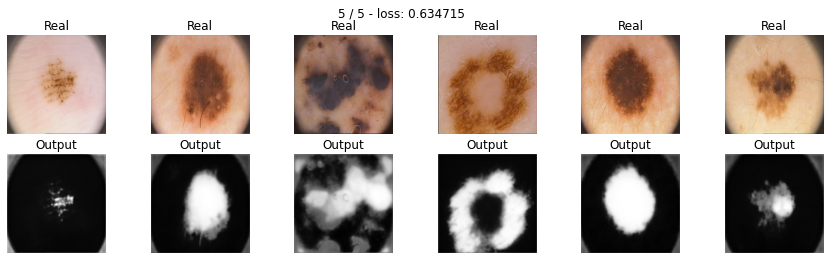

In [0]:
train(unet2_model, torch.optim.Adam(unet2_model.parameters()), bce_loss, 5, data_tr, data_val)

In [0]:
torch.cuda.empty_cache()

Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [0]:
class DilatedSegNet(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder (downsampling)
        self.enc_conv01 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bnorm01 = nn.BatchNorm2d(32)
        self.enc_conv02 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bnorm02 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False)  # 256 -> 128
 
        self.enc_conv11 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bnorm11 = nn.BatchNorm2d(64)
        self.enc_conv12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bnorm12 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False) # 128 -> 64
 
        self.enc_conv21 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bnorm21 = nn.BatchNorm2d(128)
        self.enc_conv22 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bnorm22 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False) # 64 -> 32
 
        self.enc_conv31 =nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bnorm31 = nn.BatchNorm2d(256)
        self.enc_conv32 =nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bnorm32 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=False) # 32 -> 16
 
        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)
 
        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, dilation=2, padding=1, output_padding=1) # 16 -> 32
        self.dec_conv01 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.bnorm_01 = nn.BatchNorm2d(256)
        self.dec_conv02 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_02 = nn.BatchNorm2d(128)
 
        self.upsample1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, dilation=2, padding=1, output_padding=1)
        self.dec_conv11 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bnorm_11 = nn.BatchNorm2d(128)
        self.dec_conv12 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_12 = nn.BatchNorm2d(64)
 
        self.upsample2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, dilation=2, padding=1, output_padding=1)  # 64 -> 128
        self.dec_conv21 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bnorm_21 = nn.BatchNorm2d(64)
        self.dec_conv22 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_22 = nn.BatchNorm2d(32)
 
        self.upsample3 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2, dilation=2, padding=1, output_padding=1)  # 128 -> 256
        self.dec_conv31 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bnorm_3 = nn.BatchNorm2d(32)
        self.dec_conv32 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
 
    def forward(self, x):
        # encoder
        e1 = F.relu(self.bnorm01(self.enc_conv01(x)))
        e2 = F.relu(self.bnorm02(self.enc_conv02(e1)))
        e3 = self.pool0(e2)
 
        e4 = F.relu(self.bnorm11(self.enc_conv11(e3)))
        e5 = F.relu(self.bnorm12(self.enc_conv12(e4)))
        e6 = self.pool1(e5)
       
        e7 = F.relu(self.bnorm21(self.enc_conv21(e6)))
        e8 = F.relu(self.bnorm22(self.enc_conv22(e7)))
        e9 = self.pool2(e8)
 
        e10 = F.relu(self.bnorm31(self.enc_conv31(e9)))
        e11 = F.relu(self.bnorm32(self.enc_conv32(e10)))
        e12 = self.pool3(e11)
       
        # bottleneck
        b = F.relu(self.bottleneck_conv(e12))
 
        # decoder
        d1 = self.upsample0(b)
        d2 = torch.cat([d1, e11], dim=1)
        d3 = F.relu(self.bnorm_01(self.dec_conv01(d2)))
        d4 = F.relu(self.bnorm_02(self.dec_conv02(d3)))
 
        d5 = self.upsample1(d4)
        d6 = torch.cat([d5, e8], dim=1)
        d7 = F.relu(self.bnorm_11(self.dec_conv11(d6)))
        d8 = F.relu(self.bnorm_12(self.dec_conv12(d7)))
       
        d9 = self.upsample2(d8)
        d10 = torch.cat([d9, e5], dim=1)
        d11 = F.relu(self.bnorm_21(self.dec_conv21(d10)))
        d12 = F.relu(self.bnorm_22(self.dec_conv22(d11)))
 
        d13 = self.upsample3(d12)
        d14 = torch.cat([d13, e2], dim=1)
        d15 = F.relu(self.bnorm_3(self.dec_conv31(d14)))
        d16 = torch.sigmoid(self.dec_conv32(d15))
 
        return d16

In [0]:
model = DilatedSegNet().to(device)

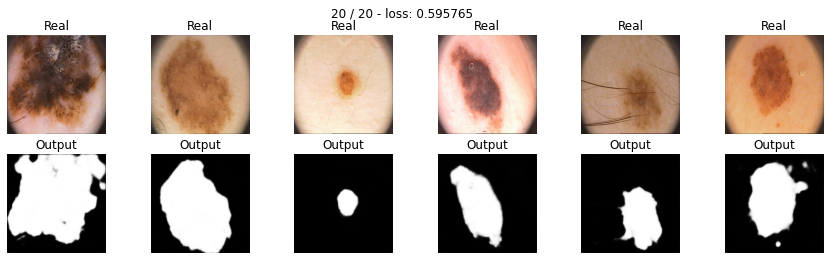

In [0]:
train(model, torch.optim.Adam(model.parameters()), bce_loss, 20, data_tr, data_val)

In [0]:
torch.cuda.empty_cache()

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



## **Здесь начинается мой текст**

Выше - были экспирименты с 4 разными моделями и 4 разными лоссами. Помимо этого, был написал трэйн, метрика, даталоадеры. Давайте постараемся сделать итог. Для этого я хочу обучить 4 модели с каждым из лоссов. Для этого я выставил одинаковое кол-во эпох, одинаковый лернинг рейт,одинаковые сиды.

In [0]:
max_epochs = 40

Обучим Segnet с четыремя разными лоссами:

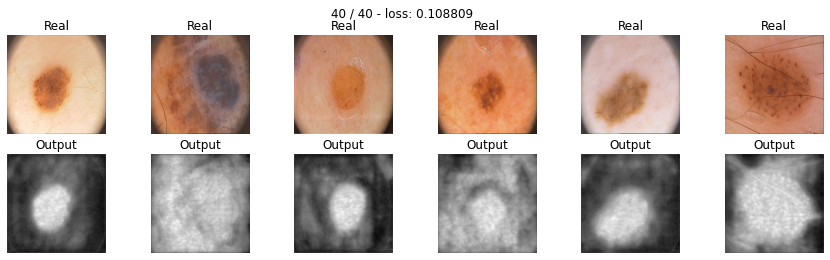

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
model = SegNet().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, optim, bce_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
segnet_bce = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

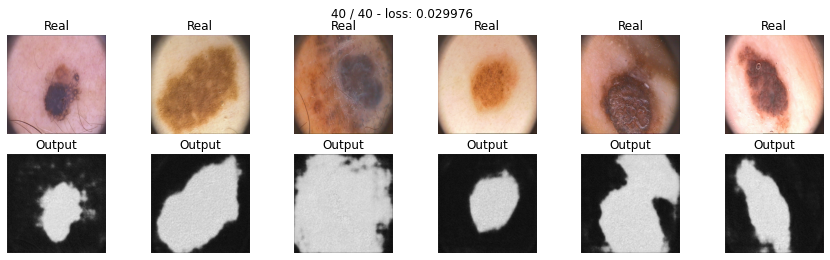

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
train(model, optim, dice_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
segnet_dice = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

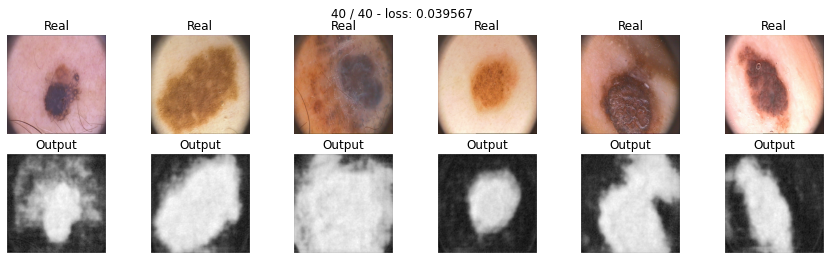

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
train(model, optim, focal_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
segnet_focal = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

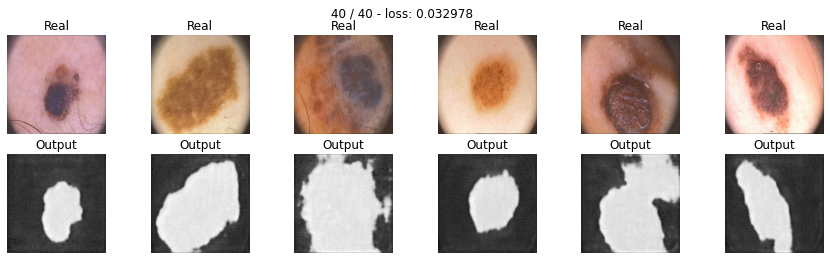

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
train(model, optim, tversky_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
segnet_tversky = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

Обучим Unet с треямя разными лоссами:

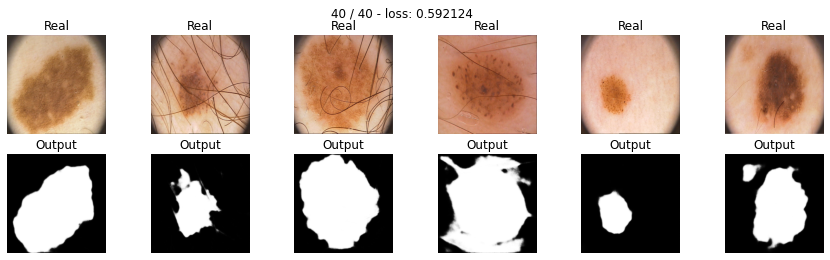

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
model = UNet().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, optim, bce_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
unet_bce = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

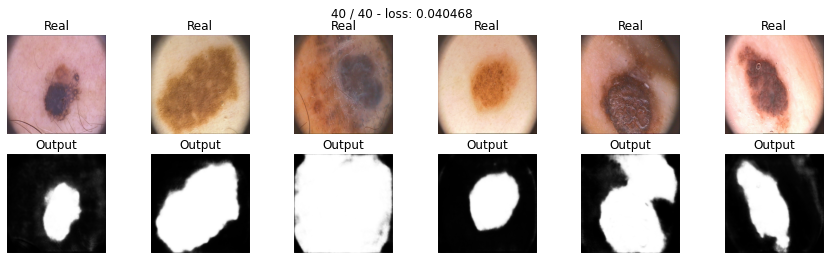

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
train(model, optim, dice_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
unet_dice = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

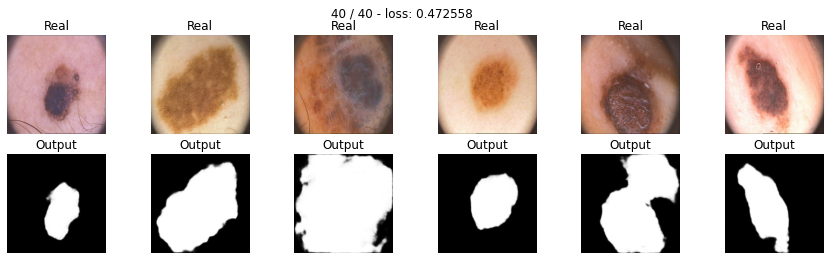

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
train(model, optim, focal_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
unet_focal = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

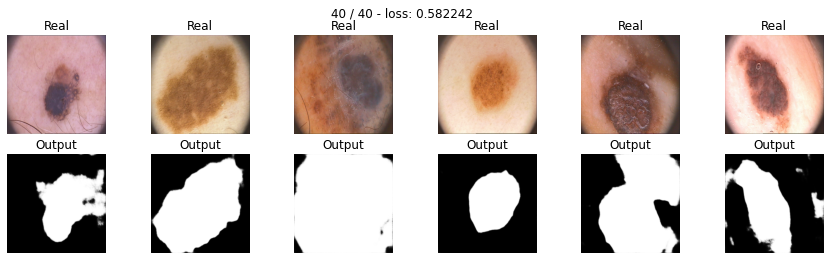

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
train(model, optim, tversky_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
unet_tversky = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

Обучим Unet2 с треямя разными лоссами:

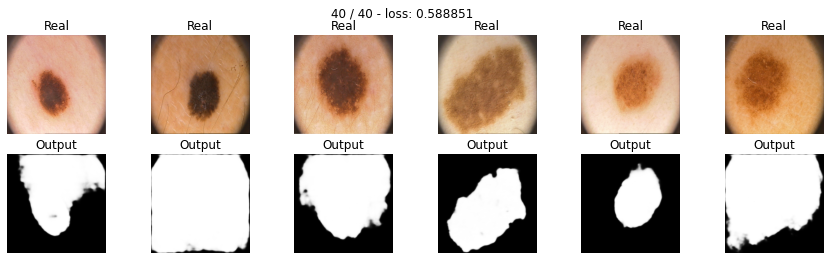

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
model = UNet2().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, optim, bce_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
unet2_bce = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

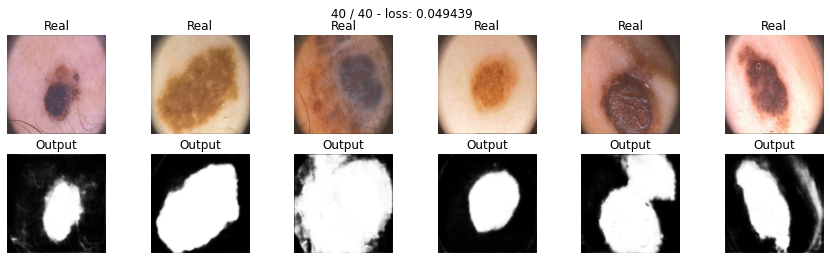

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
train(model, optim, dice_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
unet2_dice = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

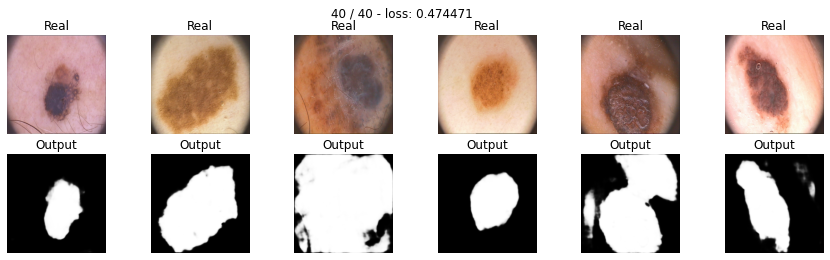

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
train(model, optim, focal_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
unet2_focal = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

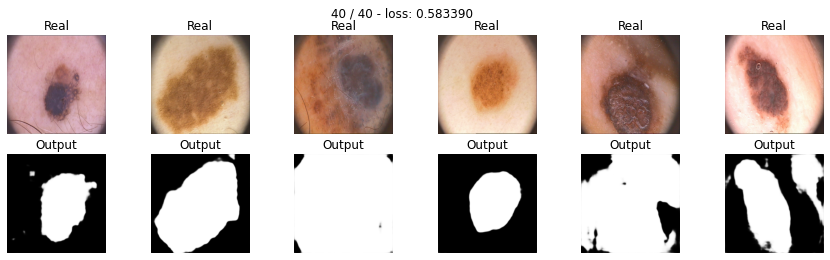

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
train(model, optim, tversky_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
unet2_tversky = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

Обучим DialetedSegNet с тремя разными лоссами:

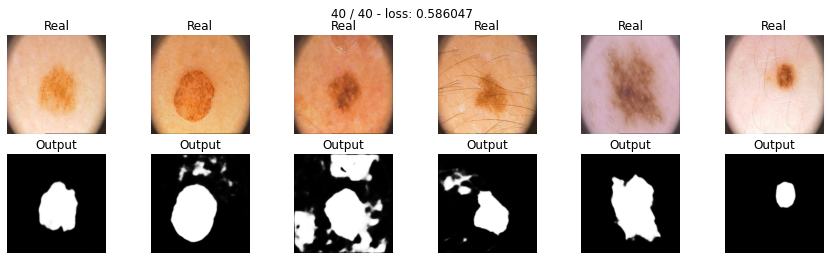

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
model = DilatedSegNet().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, optim, bce_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
dialeted_bce = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

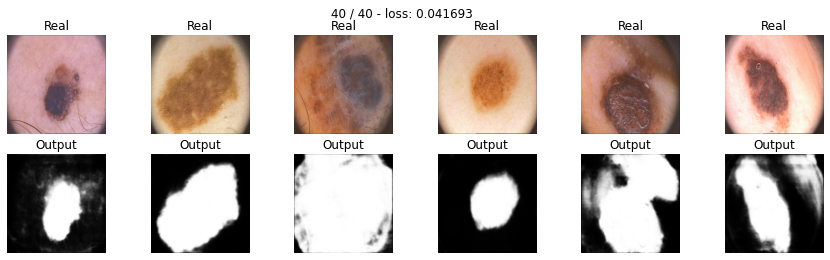

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
train(model, optim, dice_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
dialeted_dice = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

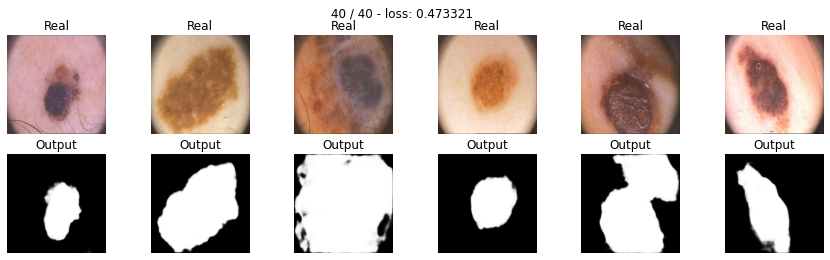

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
train(model, optim, focal_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
dialeted_focal = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

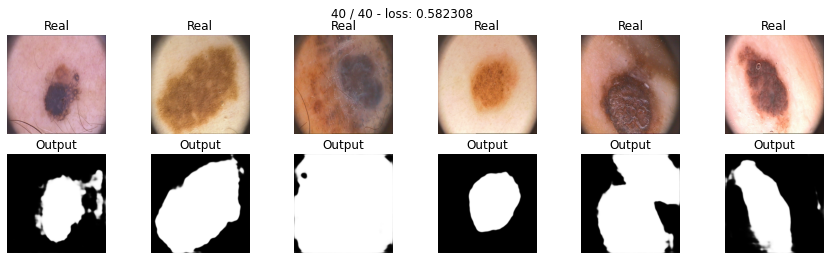

In [0]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
train(model, optim, tversky_loss, max_epochs, data_tr, data_val)
score_model(model, iou_pytorch,data_val)
dialeted_tversky = score_model(model, iou_pytorch,data_val)
torch.cuda.empty_cache()

In [0]:
print(segnet_bce, segnet_dice, segnet_focal, segnet_tversky, unet_bce, unet_dice, unet_focal, unet_tversky,  unet2_bce, unet2_dice, unet2_focal, unet2_tversky,
      dialeted_bce, dialeted_dice, dialeted_focal, dialeted_tversky)

0.6040000021457672 0.6800000071525574 0.6940000057220459 0.6860000491142273 0.578000009059906 0.6500000059604645 0.6359999775886536 0.5480000078678131 0.3620000034570694 0.6619999706745148 0.6460000276565552 0.5080000013113022 0.6459999978542328 0.6399999856948853 0.679999977350235 0.5839999914169312


### Составим датасет для отображения всего этого:

In [0]:
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
acc_scores = pd.DataFrame(data={'Model':['Segnet', 'Segnet', 'Segnet', 'Segnet',
                                         'Unet', 'Unet', 'Unet', 'Unet','Unet2', 
                                         'Unet2', 'Unet2', 'Unet2',
                                         'Dialeted', 'Dialeted', 'Dialeted', 'Dialeted'],
                                'Loss':['BCE', 'DICE', 'Focal', 'Tversky']*4,
                                'Score':[segnet_bce, segnet_dice,segnet_focal,segnet_tversky,
                                         unet_bce,unet_dice,unet_focal,unet_tversky,
                                         unet2_bce, unet2_dice, unet2_focal, unet2_tversky,
                                         dialeted_bce,dialeted_dice,dialeted_focal,dialeted_tversky]})

In [0]:
acc_scores

Model     Loss  Score
0     Segnet      BCE  0.604
1     Segnet     DICE  0.680
2     Segnet    Focal  0.694
3     Segnet  Tversky  0.686
4       Unet      BCE  0.578
5       Unet     DICE  0.650
6       Unet    Focal  0.636
7       Unet  Tversky  0.548
8      Unet2      BCE  0.362
9      Unet2     DICE  0.662
10     Unet2    Focal  0.646
11     Unet2  Tversky  0.508
12  Dialeted      BCE  0.646
13  Dialeted     DICE  0.640
14  Dialeted    Focal  0.680
15  Dialeted  Tversky  0.584

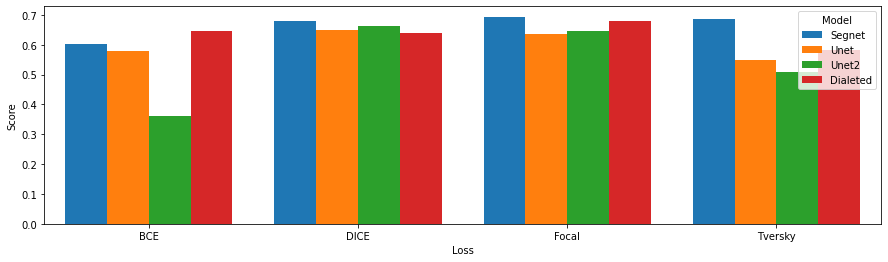

In [0]:
ax = sns.barplot("Loss", y="Score", data=acc_scores,hue='Model', saturation=1)

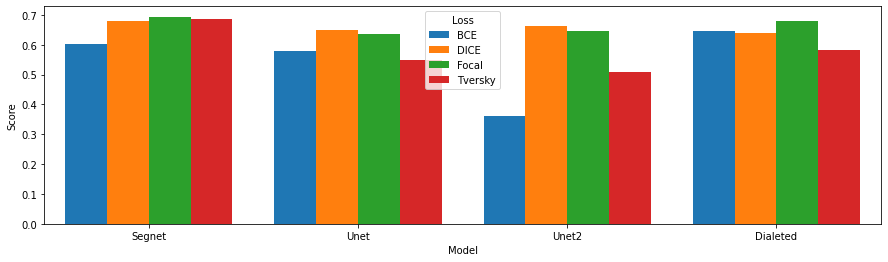

In [0]:
ax = sns.barplot("Model", y="Score", data=acc_scores,hue='Loss',saturation=1)

Главное, что хочется сказать - нельзя делать громких выводов исходя из достаточно игрушечного датасета. Да и модели, обучают по многу раз при внедрении в прод (давайте представим какие мощности у какого-то гугла, какие у них датасеты), от весов много что завсисит.

Исходя из наших тестов, удалось определить что именно под нашу задачу и нашими параметрами (эпох = 40, лр = 0.0001) лучшим будет сегнет. Непосредственно из лоссов - хорошо себя показал фокал. Собственно эта комбинация (сегнет+фокал) и дала лучший результат. Я не стал обучивать это всё на большем кол-ве эпох, потому что считаю это нечестным! Данных мало, скор будет высокий...но это же переобучение чистой воды, давайте будем играть честно, делать честные выводы.

Это домашнее задание даёт понимать, что если хочешь оценивать модель - применяй разные параметры, разные архитектуры. Тем более, мы используем демо версии архитектур. 

При всей этой возни со слоями и прочем - хочется сказать огромное спасибо Павлу qubvel, который сделал библиотеку по сегментации, которая делает вот этот вот всё в пару строчек. 

#### Огромное спасибо DLS, что дали попробовать пощупать весь мир сегментации изнутри